In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchtuples as tt 

from load import read_csv

from lifelines import KaplanMeierFitter

from pycox.models import LogisticHazard
# from pycox.models import PMF
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from tabulate import tabulate


In [84]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [85]:
datapath = './Data/data.csv'
data = read_csv(datapath)
print(len(data))

40018


0    23180
1    16838
Name: EVENT, dtype: int64

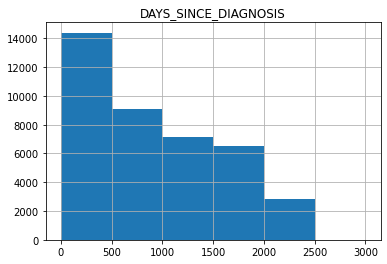

In [86]:
data.hist(column='DAYS_SINCE_DIAGNOSIS',bins=[0,500,1000,1500,2000,2500,3000])
data['EVENT'].value_counts()

In [87]:
T = data['DAYS_SINCE_DIAGNOSIS']
sites = data.columns[data.columns.str.contains('SITE_')]
median = []
for i, site in enumerate(sites):
    ix = data[site] == 1
    median.append(T[ix].median()/365*12)
to_tab = np.stack((sites, np.round(median,1)), axis=1)
print(tabulate(to_tab, headers=['Site', 'Months']))


Site        Months
--------  --------
SITE_C70      31.9
SITE_C71      11.7
SITE_C72      28.5
SITE_D32      36.7
SITE_D33      41.5
SITE_D35      44.6


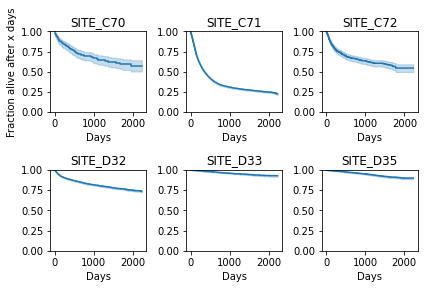

In [88]:
T = data['DAYS_SINCE_DIAGNOSIS']
E = data['EVENT']
kmf = KaplanMeierFitter()

sites = data.columns[data.columns.str.contains('SITE_')]
for i, site in enumerate(sites):
    ax = plt.subplot(2, 3, i + 1)
    
    ix = data[site] == 1
    kmf.fit(T[ix], E[ix], label=site)
    kmf.plot_survival_function(ax=ax, legend=False)

    plt.title(site)
    plt.xlabel('Days')
    plt.ylim(0.0, 1.0)
    if i==0:
        plt.ylabel('Fraction alive after x days')    
plt.tight_layout()
plt.savefig('KMcurves.svg', dpi=600,format='svg')
# C70 Malignant neoplasm of meninges
# C71 Malignant neoplasm of brain
# C72 Malignant neoplasm of spinal cord, cranial nerves and other parts of central nervous system

# D32 Benign neoplasm of meninges
# D33 Benign neoplasm of brain and other parts of central nervous system
# D35 Benign neoplasm of other and unspecified endocrine glands

In [89]:
df_test = data.sample(frac=0.2)
df_train = data.drop(df_test.index)
df_val = df_train.sample(frac=0.1)
df_train = df_train.drop(df_val.index)

In [90]:
m_brain = df_test['SITE_C71'] == 1
m_other = (df_test['SITE_C70'] == 1) | (df_test['SITE_C72'] == 1)
benign = (df_test['SITE_D32'] == 1) | (df_test['SITE_D33'] == 1) | (df_test['SITE_D35'] == 1)

print('malignant brain: ',m_brain.sum())
print('malignant other: ',m_other.sum())
print('benign: ',benign.sum())

overlap = (m_brain & m_other & benign).sum()
print(overlap)


malignant brain:  3867
malignant other:  192
benign:  3951
0


In [91]:
# cols = list(df_train.columns.values)
# print(cols)
df_train = df_train[['GRADE', 'AGE', 'SEX', 'QUINTILE_2015', 'TUMOUR_COUNT', 'SACT', 'REGIMEN_COUNT', 'CLINICAL_TRIAL_INDICATOR', 'CHEMO_RADIATION_INDICATOR', 'NORMALISED_HEIGHT', 'NORMALISED_WEIGHT', 'BENIGN_BEHAVIOUR', 'SITE_C70', 'SITE_C71', 'SITE_C72', 'SITE_D32', 'SITE_D33', 'SITE_D35', 'CREG_L0201', 'CREG_L0301', 'CREG_L0401', 'CREG_L0801', 'CREG_L0901', 'CREG_L1001', 'CREG_L1201', 'CREG_L1701', 'LAT_9', 'LAT_B', 'LAT_L', 'LAT_M', 'LAT_R', 'ETH_A', 'ETH_B', 'ETH_C', 'ETH_M', 'ETH_O', 'ETH_U', 'ETH_W', 'DAYS_TO_FIRST_SURGERY','DAYS_SINCE_DIAGNOSIS','EVENT']]
df_train.head()

,GRADE,AGE,SEX,QUINTILE_2015,TUMOUR_COUNT,SACT,REGIMEN_COUNT,CLINICAL_TRIAL_INDICATOR,CHEMO_RADIATION_INDICATOR,NORMALISED_HEIGHT,NORMALISED_WEIGHT,BENIGN_BEHAVIOUR,SITE_C70,SITE_C71,SITE_C72,SITE_D32,SITE_D33,SITE_D35,CREG_L0201,CREG_L0301,CREG_L0401,CREG_L0801,CREG_L0901,CREG_L1001,CREG_L1201,CREG_L1701,LAT_9,LAT_B,LAT_L,LAT_M,LAT_R,ETH_A,ETH_B,ETH_C,ETH_M,ETH_O,ETH_U,ETH_W,DAYS_TO_FIRST_SURGERY,DAYS_SINCE_DIAGNOSIS,EVENT
0,4,69.0,1,4.0,2,0,0.0,0,0,0.000,0.00,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,751,0
1,4,88.0,1,1.0,2,1,5.0,0,0,1.755,71.75,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,17,1
2,4,79.0,1,2.0,2,0,0.0,0,0,0.000,0.00,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,252,1
5,-1,28.0,1,1.0,2,0,0.0,0,0,0.000,0.00,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,839,0
7,-1,65.0,1,2.0,2,0,0.0,0,0,0.000,0.00,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,12,770,0


In [92]:
cols_standardise = ['GRADE', 'AGE', 'QUINTILE_2015', 'NORMALISED_HEIGHT', 'NORMALISED_WEIGHT']
cols_minmax = ['SEX', 'TUMOUR_COUNT', 'REGIMEN_COUNT']
cols_leave = ['SACT', 'CLINICAL_TRIAL_INDICATOR', 'CHEMO_RADIATION_INDICATOR','BENIGN_BEHAVIOUR','SITE_C70', 'SITE_C71', 'SITE_C72', 'SITE_D32','SITE_D33','SITE_D35','CREG_L0201','CREG_L0301','CREG_L0401','CREG_L0801','CREG_L0901','CREG_L1001','CREG_L1201','CREG_L1701','LAT_9','LAT_B','LAT_L','LAT_M','LAT_R','ETH_A','ETH_B','ETH_C','ETH_M','ETH_O','ETH_U','ETH_W','DAYS_TO_FIRST_SURGERY']

print(len(df_train.columns) == len(cols_standardise + cols_minmax + cols_leave))

standardise = [([col], StandardScaler()) for col in cols_standardise]
minmax = [([col], MinMaxScaler()) for col in cols_minmax]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardise + minmax + leave)

False


In [93]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [94]:
num_durations = 50

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df.DAYS_SINCE_DIAGNOSIS.values, df.EVENT.values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [95]:
labtrans.cuts

array([   0.        ,   45.53061224,   91.06122449,  136.59183673,
        182.12244898,  227.65306122,  273.18367347,  318.71428571,
        364.24489796,  409.7755102 ,  455.30612245,  500.83673469,
        546.36734694,  591.89795918,  637.42857143,  682.95918367,
        728.48979592,  774.02040816,  819.55102041,  865.08163265,
        910.6122449 ,  956.14285714, 1001.67346939, 1047.20408163,
       1092.73469388, 1138.26530612, 1183.79591837, 1229.32653061,
       1274.85714286, 1320.3877551 , 1365.91836735, 1411.44897959,
       1456.97959184, 1502.51020408, 1548.04081633, 1593.57142857,
       1639.10204082, 1684.63265306, 1730.16326531, 1775.69387755,
       1821.2244898 , 1866.75510204, 1912.28571429, 1957.81632653,
       2003.34693878, 2048.87755102, 2094.40816327, 2139.93877551,
       2185.46938776, 2231.        ])

In [96]:
in_features = x_train.shape[1]
num_nodes = [32, 32, 32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [97]:
model = LogisticHazard(net, tt.optim.Adam(0.001), duration_index=labtrans.cuts)
# model = PMF(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [98]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [99]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 12.8610,	val_loss: 9.8624
1:	[0s / 0s],		train_loss: 7.1205,	val_loss: 3.9611
2:	[0s / 1s],		train_loss: 3.0354,	val_loss: 2.2282
3:	[0s / 1s],		train_loss: 2.1476,	val_loss: 1.9136
4:	[0s / 2s],		train_loss: 1.9346,	val_loss: 1.7995
5:	[0s / 2s],		train_loss: 1.8617,	val_loss: 1.7570
6:	[0s / 3s],		train_loss: 1.8256,	val_loss: 1.7365
7:	[0s / 3s],		train_loss: 1.8013,	val_loss: 1.7254
8:	[0s / 3s],		train_loss: 1.7958,	val_loss: 1.7166
9:	[0s / 4s],		train_loss: 1.7814,	val_loss: 1.7103
10:	[0s / 4s],		train_loss: 1.7731,	val_loss: 1.7057
11:	[0s / 5s],		train_loss: 1.7698,	val_loss: 1.7044
12:	[0s / 5s],		train_loss: 1.7608,	val_loss: 1.7014
13:	[0s / 6s],		train_loss: 1.7580,	val_loss: 1.7002
14:	[0s / 6s],		train_loss: 1.7595,	val_loss: 1.6989
15:	[0s / 6s],		train_loss: 1.7487,	val_loss: 1.6968
16:	[0s / 7s],		train_loss: 1.7481,	val_loss: 1.6976
17:	[0s / 7s],		train_loss: 1.7469,	val_loss: 1.6967
18:	[0s / 8s],		train_loss: 1.7432,	val_loss: 1.6943
19

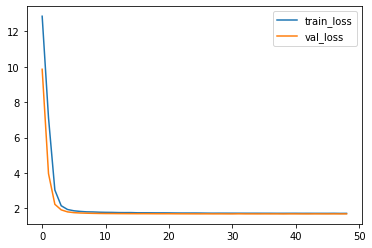

In [100]:
_ = log.plot()

In [101]:
# surv has n columns and t rows (as many as there are cuts)
surv = model.predict_surv_df(x_test)
surv.shape

(50, 8004)

In [102]:
# interpolate intermediate steps between each pair of cuts
surv = model.interpolate(10).predict_surv_df(x_test)
surv.shape

(491, 8004)

Int64Index([3, 4, 7, 13, 14], dtype='int64')
Int64Index([5, 89, 104, 128, 157], dtype='int64')
Int64Index([0, 1, 2, 6, 8], dtype='int64')


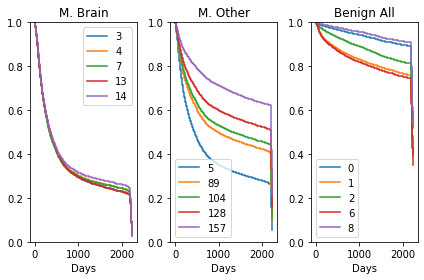

In [103]:
to_plot = ['M. Brain', 'M. Other', 'Benign All']
m_brain = m_brain.reset_index(drop=True)
m_other = m_other.reset_index(drop=True)
benign = benign.reset_index(drop=True)

idx = [m_brain.where(m_brain == True).dropna().head(5),
        m_other.where(m_other == True).dropna().head(5),
        benign.where(benign == True).dropna().head(5)]

for i, site in enumerate(to_plot):
    ax = plt.subplot(1, 3, i + 1)
    
    ix = idx[i].index
    print(ix)
    surv.iloc[:, ix].plot(ax=ax, drawstyle='steps-post')
    
    plt.title(site)
    plt.xlabel('Days')
    plt.ylim(0.0, 1.0)
plt.tight_layout()


In [104]:
pd.set_option('display.max_columns', None)
df_test.iloc[m_brain.where(m_brain == True).dropna().head(5).index]

,PATIENTID,GRADE,AGE,SEX,QUINTILE_2015,TUMOUR_COUNT,SACT,REGIMEN_COUNT,CLINICAL_TRIAL_INDICATOR,CHEMO_RADIATION_INDICATOR,NORMALISED_HEIGHT,NORMALISED_WEIGHT,DAYS_TO_FIRST_SURGERY,DAYS_SINCE_DIAGNOSIS,SITE_C70,SITE_C71,SITE_C72,SITE_D32,SITE_D33,SITE_D35,BENIGN_BEHAVIOUR,CREG_L0201,CREG_L0301,CREG_L0401,CREG_L0801,CREG_L0901,CREG_L1001,CREG_L1201,CREG_L1701,LAT_9,LAT_B,LAT_L,LAT_M,LAT_R,ETH_A,ETH_B,ETH_C,ETH_M,ETH_O,ETH_U,ETH_W,EVENT
17728,210018622,3,59.0,1,2.0,1,0,0.0,0,0,0.0,0.0,0,9,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
3918,210002828,2,32.0,1,2.0,1,0,0.0,0,0,0.0,0.0,12,2205,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
11657,210011462,-1,36.0,2,4.0,1,0,0.0,0,0,0.0,0.0,12,537,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1
6128,210005220,4,71.0,2,4.0,1,0,0.0,0,0,0.0,0.0,0,195,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
15035,210015399,1,8.0,1,1.0,1,0,0.0,0,0,0.0,0.0,0,479,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1


In [105]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td('antolini')

0.7500415136824381